# Use TIGER/Lines edges

Observation:
- Many / most of the crime events seem to fall (nearly) exactly onto the edges in the TIGER/Lines edges database

So perhaps we could assign events to the edge, and use this as a way of finding a canonical address name.

- Sadly, this doesn't work.
- A number of places don't have "edges" associated with them.
- I found cases where there are _two_ edges directly over one another with different names
- I found cases where Google maps/ OSM and the crime data _almost_ agree, but the edge data is rather different.

So, again, to do this would again seem to require a massive amount of manual cleaning.


# Preprocess the TIGER Line shapefile

Into something we can more easily read...

In [6]:
import os
import geopandas as gpd

In [7]:
datadir = os.path.join("/media", "disk", "TIGER Data")
filename = os.path.join(datadir, "tl_2016_17031_edges")
frame = gpd.GeoDataFrame.from_file(filename)

In [8]:
frame.head()

,ARTPATH,COUNTYFP,DECKEDROAD,DIVROAD,EXTTYP,FEATCAT,FULLNAME,GCSEFLG,HYDROFLG,LFROMADD,...,STATEFP,TFIDL,TFIDR,TLID,TNIDF,TNIDT,TTYP,ZIPL,ZIPR,geometry
0,None,031,None,None,N,None,None,N,N,None,...,17,205026959,250409380,630009250,419075567,66443071,None,None,None,"LINESTRING (-87.55868599999998 41.773792, -87...."
1,N,031,None,None,N,L,Great Lakes,N,N,None,...,17,227443517,227443516,613720666,407309993,407309994,None,None,None,"LINESTRING (-87.573183 41.779229, -87.57340999..."
2,None,031,None,None,N,None,None,N,N,None,...,17,250409506,257825701,630009366,419075613,419075603,None,None,None,LINESTRING (-87.62733999999999 41.942534999999...
3,None,031,None,None,N,None,None,N,N,None,...,17,250409499,250409498,630009476,66489213,419075651,None,None,None,"LINESTRING (-87.63421699999999 41.969819, -87...."
4,None,031,None,None,N,None,None,N,N,None,...,17,250409386,250409320,630009160,419075532,419075537,None,None,None,"LINESTRING (-87.569547 41.78121, -87.563009999..."


In [13]:
out = frame[["FULLNAME", "LFROMADD", "LTOADD", "RFROMADD", "RTOADD"]]
out = gpd.GeoDataFrame(out)
out.geometry = frame.geometry
out.crs = frame.crs
out.head()

,FULLNAME,LFROMADD,LTOADD,RFROMADD,RTOADD,geometry
0,None,None,None,None,None,"LINESTRING (-87.55868599999998 41.773792, -87...."
1,Great Lakes,None,None,None,None,"LINESTRING (-87.573183 41.779229, -87.57340999..."
2,None,None,None,None,None,LINESTRING (-87.62733999999999 41.942534999999...
3,None,None,None,None,None,"LINESTRING (-87.63421699999999 41.969819, -87...."
4,None,None,None,None,None,"LINESTRING (-87.569547 41.78121, -87.563009999..."


In [18]:
import pickle
d = pickle.dumps(out)
import lzma
d = lzma.compress(d)
with open("chicago_edge.pic.lz", "wb") as f:
    f.write(d)

# Main section

Aim is to try to link the points to edges, and so normalise the street names...

In [1]:
import pickle, lzma
import geopandas as gpd
with open("chicago_edge.pic.lz", "rb") as f:
    edges = pickle.loads(lzma.decompress(f.read()))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma, csv, bz2, io, collections, pickle
import pyproj
import tilemapbase
import shapely.geometry

import open_cp.sources.chicago

In [3]:
data_dir = os.path.join("/media", "disk", "Data")
#data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

In [4]:
with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(list)
    data = []
    for row in reader:
        if row[15] == "":
            continue
        year = int(row[17])
        if year <= 2001:
            continue
        block, x, y = row[3], float(row[15]), float(row[16])
        x /= open_cp.sources.chicago._FEET_IN_METERS
        y /= open_cp.sources.chicago._FEET_IN_METERS
        if x < 10 or y < 10:
            continue
        out[block].append((x,y))
        data.append((block, x, y, row[5], row[6], row[7]))
out = {k : np.asarray(out[k]) for k in out}
len(out)

51465

In [5]:
proj = pyproj.Proj({"init":"epsg:3528"})
edges = edges.to_crs({"init" : "epsg:3528"})

In [6]:
#edges = edges[edges.FULLNAME.notnull()].copy()

# Find closest edges

Again, we'll use `rtree`

In [7]:
import rtree

In [8]:
def gen():
    for i, row in edges.iterrows():
        yield i, row.geometry.bounds, None
index = rtree.index.Index(gen())

In [9]:
def find_closest_rtree(point):
    h = 1
    x, y = list(point.coords)[0]
    while True:
        options = list( index.intersection((x-h,y-h, x+h,y+h)) )
        if len(options) > 0:
            break
        h += h
    dist = [edges.geometry[i].distance(point) for i in options]
    i = options[np.argmin(dist)]
    name = edges.FULLNAME[i]
    if name is None:
        return name
    return name.upper()

In [10]:
import collections

def majority(pts):
    choices = [ find_closest_rtree( shapely.geometry.Point(*p) ) for p in pts ]
    c = collections.Counter(choices)
    for name, _ in c.most_common():
        if name is not None:
            return name

def street(block):
    i = block.find(" ")
    return block[i+1:]

In [19]:
pts = out["039XX N LAKE SHORE DR"]
choices = [ find_closest_rtree( shapely.geometry.Point(*p) ) for p in pts ]
c = collections.Counter(choices)
c.most_common()

[('LAKE SHORE DR', 422)]

In [12]:
majority(pts)

In [14]:
known_problems = {"S EUCLID PKWY", "S DREXEL AVE"}

for key in out:
    st = street(key)
    if st in known_problems:
        continue
    computed = majority( out[key] )
    if computed != st:
        print(key, "-->", computed)
        assert computed is not None

035XX W LE MOYNE ST --> W LEMOYNE ST
130XX S DREXEL AVE --> E 131ST ST
134XX S AVENUE O --> S AVE O
060XX N BROADWAY --> N BROADWAY ST
019XX W HOWARD ST --> HOWARD ST
039XX N LAKE SHORE DR --> LAKE SHORE DR
002XX W MONTROSE HARBOR DR --> MONTROSE DR
096XX S AVENUE M --> S AVE M
077XX S CREGIER AVE --> S CREGIER
004XX E SOUTH WATER ST --> E SOUTHWATER ST
012XX N SANDBURG TER --> W GOETHE ST
069XX S STATE ST --> STATE ST
0000X W CTA 95TH ST LN --> None


AssertionError: 

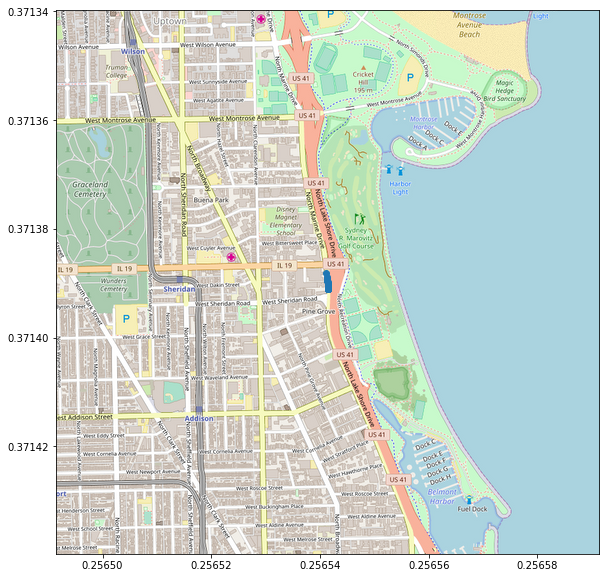

In [20]:
pts = out["039XX N LAKE SHORE DR"]

fig, ax = plt.subplots(figsize=(10,10))

x,y = np.mean(pts, axis=0)
x,y = tilemapbase.project(*proj(x, y, inverse=True))
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

pts_tmb = []
for x, y in zip(*proj(*pts.T, inverse=True)):
    pts_tmb.append(tilemapbase.project(x,y))
pts_tmb = np.asarray(pts_tmb)
ax.scatter(*pts_tmb.T)